<a href="https://colab.research.google.com/github/Tornom/TrabalhosFaculdade/blob/master/sel0620_tarefa4_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SEL0620 - Controle Digital

**Nome do(s) Aluno(s):** Lucas Albano de Oliveira

**N.USP:** 10377688

**Exercício Individual ou em dupla. Peso 1.**


## Preparação do ambiente do Colab

Instala a biblioteca de controle 

In [98]:
# !pip install slycot # biblioteca opcional
!pip install control --quiet 

Carrega bibiotecas 

In [99]:
import os
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import control as ct
from control.matlab import *

Coloque a seguir as definições das funções implementadas em práticas anteriores que você deseja utilizar nesta prática:

In [100]:
#Variáveis
s = tf('s')
s2 = s*s

#Parâmetros
K = 8
tau = 0.5
wn = 89
wn2 = wn*wn

#Função de Transferência 
G1 = (K*wn2)/(s2+2*tau*wn*s+wn2)

#Print da função 
#print('G(s) = ', G1)

Ta = 1/1116.95 #Período de amostragem
G1d = G1.sample(Ta,'zoh')
#print(G1d)


def valor_final(Gs):
  c_final = 0

  y, t = step(Gs)

  c_final = round(y[-1])

  return c_final

def valor_maximo(Gs):
  c_max = 0

  y, t = step(Gs)

  c_max = y.max()

  return c_max

def tempo_subida(Gs):
  Tr = 0
  index1 = 0
  index2 = 0
  b1 = False
  b2 = False

  y, t = step(Gs)

  f = valor_final(Gs)

  for idx,val in enumerate(y):
    if val >= 0.1*f and not b1:
      index1 = idx
      b1 = True
    elif val >= 0.9*f and not b2:
      index2 = idx
      b2 = True

  Tr = t[index2] - t[index1] 

  return Tr

def tempo_pico_sobressinal(Gs):
  Tp = 0
  Mp = 0
  
  y, t = step(Gs)

  max = valor_maximo(Gs)
  final = valor_final(Gs)

  index = np.where(y == max)

  Tp = t[index[0][0]]

  Mp = (max - final)/final

  return Tp, Mp

def tempo_acomodacao(Gs):
  Ts = 0

  y, t = step(Gs)

  tamanho = len(y)

  index = next(tamanho-i for i in range(2,tamanho-1)if abs(y[-i]/y[-1])>1.02)

  Ts = t[index]-t[0]

  return Ts


def sinal_erro(gs):

  err = 1 - gs # E(s) = r(s) - Y(s)

  return err

def lim_sinal_erro(KP):
  ess = 1/(1+K*KP)

  return ess

## Projeto de Controladores

Considere o sistema de segunda ordem utilizado nas práticas anteriores e representado pela função de transferência:

$$ G_p(s) = K \frac{w_n^2}{s^2 + 2 \zeta w_n s + w_n^2} $$

Utilize os parâmetros $K$, $\zeta$, e $w_n$ indicados na tabela disponível no Moodle, de acordo com o N.USP de um dos integrantes do grupo. Utilize os mesmos parâmetros da prática anterior para dar continuidade ao projeto.



### Controle Proporcional Contínuo

Nesta etapa, um controlador proporcional $C(s) = K_p$ será projetado para controlar o sistema em malha fechada. A Figura 1 mostra o diagrama contínuo de controle com realimentação unitária em que a planta está sujeita a um distúrbio na entrada.



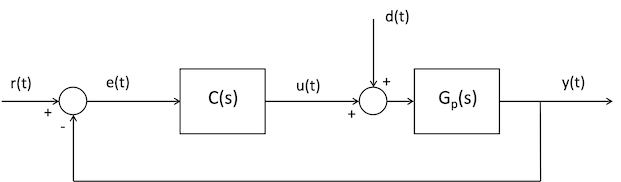

Figura 1 - Sistema de malha fechada com realimentação unitária

Desconsiderando o distúrbio na entrada da planta, a função contínua de malha fechada do sistema é dada por:
\begin{align*}
& G_{MF}(s) = \frac{Y(s)}{R(s)} = \frac{C(s)G_p(s)}{1+C(s)G_p(s)}
\end{align*}

O erro do sistema em relação ao sinal de referência da malha fechada é dado por:
\begin{align*}
& E(s) = R(s) - Y(s) = R(s)\left(1 - \frac{C(s)G_p(s)}{1+C(s)G_p(s)}\right) = \frac{R(s)}{1+C(s)G_p(s)}
\end{align*}

Portanto, para um sinal de referência do tipo degrau de amplitude $A$: 
\begin{align*}
& R(s) = \frac{A}{s}
\end{align*}
e o erro pode ser dado por:
\begin{align*}
& E(s) =  \frac{A}{s(1+C(s)G_p(s))}
\end{align*}

O erro em regime permanente em valor absoluto, desconsiderando distúrbio na entrada da planta, considerando uma entrada degrau de ampliture $A$, a planta do sistema de segunda ordem $G_p(s)$, e controlador proporcional $C(s) = K_p$, pode ser calculado através do teorema do valor final:
\begin{align*}
& e_{ss} = \lim_{t \rightarrow \infty} e(t) = \lim_{s \rightarrow 0} s E(s) = \frac{A}{(1+K K_p)}
\end{align*}

### Implementação das funções para simular a malha fechada

A partir desta prática, ao se trabalhar com sistemas de malha fechada, é importante mostrar os seguintes sinais indicados na Figura 1:

* Referência, $r(t)$, que é o sinal de entrada do sistema de malha fechada que serve como referência a ser seguida pelo sistema. Ou seja, deseja-se que o sinal de saída $y(t)$ seja o mais próximo possível, ou até mesmo igual a $r(t)$;

* Saída da planta, $y(t)$, é o sinal que se deseja controlar, de interesse para o problema de controle, e portanto será medido por um sensor e realimentado para comparação com o sinal de referência. A saída da planta $G_p(s)$ geralmente é a saída do sistema de malha fechada.

* Erro do sistema, $e(t)$, é a diferença entre a referência e a saída da planta, ou seja, $y(t) = r(t) - y(t)$. Para sistemas com realimentação unitária, o sinal de erro é a saída do comparador.

* Sinal de controle, $u(t)$, é o sinal gerado pelo controlador, ou seja, a saída de $C(s)$.

* Distúrbio na entrada da planta, $d(s)$, é um sinal que pode ser adicionado ao sinal de controle antes da entrada na planta. Geralmente é utilizado para simular e testar a capacidade do sistema de malha fechada de seguir a referência mesmo em condições diferentes da ideal.

* Entrada na planta, $u_d(t) = u(t) + d(t)$.

Os sinais $r(t)$ e $d(t)$ em geral são definidos e fornecidos ao sistema para a simulação.

Os sinais sinais de erro $e(t)= r(t) - y(t)$, e o sinal de entrada na planta $u_d(t) = u(t) + d(t)$, são facilmente obtidos a partir de $r(t)$, $d(t)$, $y(t)$, e $u(t)$.

Entretanto, os sinais $u(t)$ e $y(t)$ devem ser gerados de forma apropriada para a simulação. Nesta tarefa, o distúrbio $d(t)$ será desconsiderado.

#### Saída do sistema desconsiderando distúrbio

Desconsiderando o distúrbio, a função de transferência que relaciona a saída e a referência do sistema de malha fechada é dada por:

$$ G_{mf}(s) = \frac{Y(s)}{R(s)} = \frac{C(s) G_p(s)}{1+C(s)G_p(s)}$$

Ela pode ser implementada na biblioteca de controle em Python utilizando o comando [`feedback`](https://python-control.readthedocs.io/en/0.9.0/generated/control.matlab.feedback.html#control.matlab.feedback) ou manipulando algebricamente as funções de transferência.

A seguir implemente uma função que dado a função de transferência do controlador $C(s)$, e a função de transferência de planta $G_p(s)$, retorna a função de transferência $Y(s)/R(s)$.


In [101]:
def ft_saida_referencia(ft_planta,ft_controlador):
  ft_r2y = ct.feedback(ct.series(ft_planta,ft_controlador),1,-1)
  return ft_r2y

#### Sinal de controle desconsiderando distúrbio

Desconsiderando o distúrbio, encontre a função de transferência que relaciona o sinal de controle $U(s)$ com a referência do sistema de malha fechada $R(s)$:

$$ \frac{U(s)}{R(s)} = ? $$

Implemente em python a função de transferência encontrada:


In [102]:
def ft_controle_referencia(ft_planta,ft_controlador):
  ft_r2u = ft_controlador/(1+(ft_controlador*ft_planta))
  
  return ft_r2u

### Projeto e Simulação


#### Caso 1:

Considere o sistema de malha fechada da Figura 1, desconsiderando disturbio, ou seja, para $d = 0$. Considere referência degrau unitário, $r(t)=1(t)$ e controlador proporcional $C(s) = K_p = 1$. Obtenha os seguintes sinais de resposta:

1. Saída do sistema, $y(t)$, sobreposta com a referência degrau unitário, r(t) = 1(t), mostrando as características de desempenho da resposta de malha fechada (ver tarefa 2).

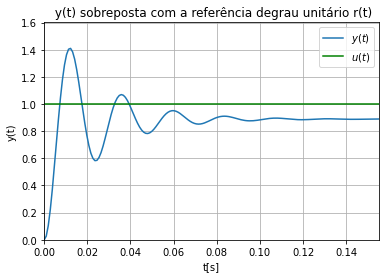

Valor final:1
Valor maximo:1.409927435901333
Tempo Subida:0.005644743843907774
Tempo de Acomodacao:0.0846711576586166
Tempo de pico e sobresinal:(0.012230278328466843, 0.40992743590133296)


In [103]:
C = 1
A = 1

S = ft_saida_referencia(G1,C)

y, t = step(S) # Y(s)
plt.plot(t, y)

r = A*np.ones(np.shape(y))

plt.plot(t, r, 'g')

plt.ylabel('y(t)')
plt.xlabel('t[s]')
plt.title(' y(t) sobreposta com a referência degrau unitário r(t)')
plt.legend(['$y(t)$','$u(t)$'])
plt.axis([0,t[-1],0,1.8*y[-1]])
plt.grid(True)
plt.show(block=False)


print("Valor final:"+str(valor_final(S)))
print("Valor maximo:"+str(valor_maximo(S)))
print("Tempo Subida:"+str(tempo_subida(S)))
print("Tempo de Acomodacao:"+str(tempo_acomodacao(S)))
print("Tempo de pico e sobresinal:"+str(tempo_pico_sobressinal(S)))



* Relacione a seguir os valores de cada uma das características de desempenho da curva de saída de malha fechada, ou seja, da resposta de malha fechada a uma entrada degrau (ver tarefa 2):

* $c_{final} = 1$
* $c_{max} = 1.4099$
* $T_r = 0.0056$
* $T_s = 0.0847$
* $T_p = 0.0122$
* $M_p = 0.4099$

---





2. Sinal de erro, $e(t)$:

Limite do sinal de erro: 0.1111111111111111

  s^2 + 89 s + 7921
----------------------
s^2 + 89 s + 7.129e+04



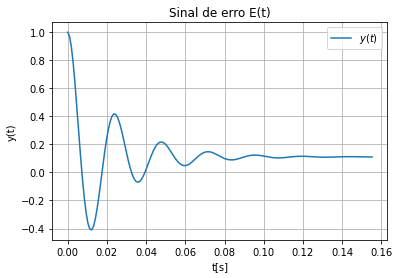

In [104]:

print("Limite do sinal de erro: "+str(lim_sinal_erro(C)))

E = sinal_erro(S) # E(s) = r(s)-Y(s)
print(E)

y, t = step(E)
plt.plot(t, y)

r = A*np.ones(np.shape(y))



plt.ylabel('y(t)')
plt.xlabel('t[s]')
plt.title('Sinal de erro E(t)')
plt.legend(['$y(t)$'])

plt.grid(True)
plt.show(block=False)


* Valor final do sinal do erro: 0.1111
* Porcentagem do erro em relação ao valor de entrada: 11.11%


---



3. Sinal de controle, $u(t)$:


  s^2 + 89 s + 7921
----------------------
s^2 + 89 s + 7.129e+04

Valor maximo:1.0


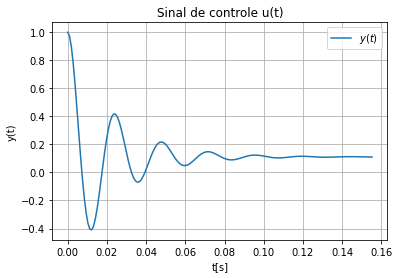

In [105]:
Sc = ft_controle_referencia(G1,C)
print(Sc)
print("Valor maximo:"+str(valor_maximo(Sc)))
y, t = step(Sc)
plt.plot(t, y)

r = A*np.ones(np.shape(y))

plt.ylabel('y(t)')
plt.xlabel('t[s]')
plt.title('Sinal de controle u(t)')
plt.legend(['$y(t)$'])

plt.grid(True)
plt.show(block=False)


* Valor máximo do módulo do sinal de controle: 1



---



#### Caso 2:

Para as mesmas condições do caso 1, mas considerando um controlador proporcional $C(s) = K_p = 5$, obtenha os seguintes sinais de resposta:

1. Saída do sistema, $y(t)$, sobreposta com a referência degrau unitário, r(t) = 1(t). Características de desempenho da resposta de malha fechada.

2. Sinal de erro, $e(t)$. Valor final do sinal do erro. Porcentagem do erro em relação ao valor de entrada.

3. Sinal de controle, $u(t)$. Valor máximo do módulo do sinal de controle.





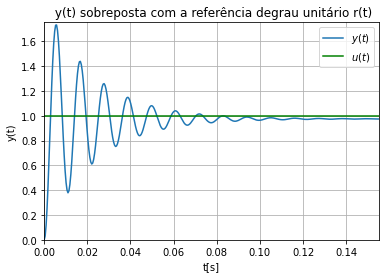

Valor final:1
Valor maximo:1.7333248041969158
Tempo Subida:0.002204978064026474
Tempo de Acomodacao:0.08378916643300602
Tempo de pico e sobresinal:(0.0057329429664688325, 0.7333248041969158)


In [106]:
C = 5
A = 1

S = ft_saida_referencia(G1,C)

y, t = step(S) # Y(s)
plt.plot(t, y)

r = A*np.ones(np.shape(y))

plt.plot(t, r, 'g')

plt.ylabel('y(t)')
plt.xlabel('t[s]')
plt.title(' y(t) sobreposta com a referência degrau unitário r(t)')
plt.legend(['$y(t)$','$u(t)$'])
plt.axis([0,t[-1],0,1.8*y[-1]])
plt.grid(True)
plt.show(block=False)


print("Valor final:"+str(valor_final(S)))
print("Valor maximo:"+str(valor_maximo(S)))
print("Tempo Subida:"+str(tempo_subida(S)))
print("Tempo de Acomodacao:"+str(tempo_acomodacao(S)))
print("Tempo de pico e sobresinal:"+str(tempo_pico_sobressinal(S)))


Limite do sinal de erro: 0.024390243902439025

  s^2 + 89 s + 7921
----------------------
s^2 + 89 s + 3.248e+05



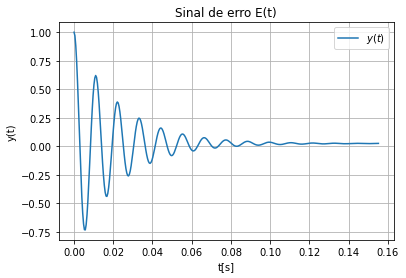

In [107]:
print("Limite do sinal de erro: "+str(lim_sinal_erro(C)))

E = sinal_erro(S) # E(s) = r(s)-Y(s)
print(E)

y, t = step(E)
plt.plot(t, y)

r = A*np.ones(np.shape(y))



plt.ylabel('y(t)')
plt.xlabel('t[s]')
plt.title('Sinal de erro E(t)')
plt.legend(['$y(t)$'])

plt.grid(True)
plt.show(block=False)




5 s^2 + 445 s + 3.960e+04
-------------------------
 s^2 + 89 s + 3.248e+05

Valor maximo:5.0


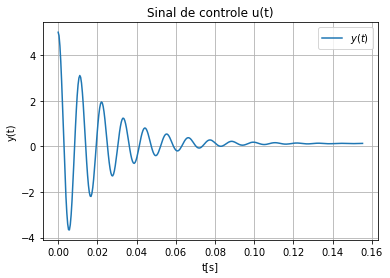

In [108]:

Sc = ft_controle_referencia(G1,C)
print(Sc)
print("Valor maximo:"+str(valor_maximo(Sc)))
y, t = step(Sc)
plt.plot(t, y)

r = A*np.ones(np.shape(y))

plt.ylabel('y(t)')
plt.xlabel('t[s]')
plt.title('Sinal de controle u(t)')
plt.legend(['$y(t)$'])

plt.grid(True)
plt.show(block=False)

---

#### Caso 3

Para as mesmas condições do caso 1, mas considerando um controlador proporcional $C(s) = K_p = 8$, obtenha os seguintes sinais de resposta:

1. Saída do sistema, $y(t)$, sobreposta com a referência degrau unitário, r(t) = 1(t). Características de desempenho da resposta de malha fechada.

2. Sinal de erro, $e(t)$. Valor final do sinal do erro. Porcentagem do erro em relação ao valor de entrada.

3. Sinal de controle, $u(t)$. Valor máximo do módulo do sinal de controle.

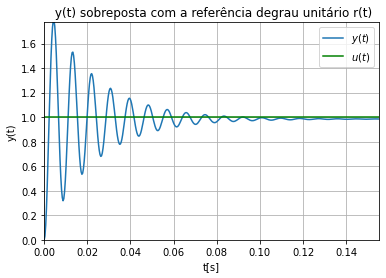

Valor final:1
Valor maximo:1.789425396700986
Tempo Subida:0.0017480907174263938
Tempo de Acomodacao:0.0839083544364669
Tempo de pico e sobresinal:(0.004545035865308624, 0.7894253967009861)


In [109]:
C = 8
A = 1

S = ft_saida_referencia(G1,C)

y, t = step(S) # Y(s)
plt.plot(t, y)

r = A*np.ones(np.shape(y))

plt.plot(t, r, 'g')

plt.ylabel('y(t)')
plt.xlabel('t[s]')
plt.title(' y(t) sobreposta com a referência degrau unitário r(t)')
plt.legend(['$y(t)$','$u(t)$'])
plt.axis([0,t[-1],0,1.8*y[-1]])
plt.grid(True)
plt.show(block=False)


print("Valor final:"+str(valor_final(S)))
print("Valor maximo:"+str(valor_maximo(S)))
print("Tempo Subida:"+str(tempo_subida(S)))
print("Tempo de Acomodacao:"+str(tempo_acomodacao(S)))
print("Tempo de pico e sobresinal:"+str(tempo_pico_sobressinal(S)))


Limite do sinal de erro: 0.015384615384615385

  s^2 + 89 s + 7921
----------------------
s^2 + 89 s + 5.149e+05



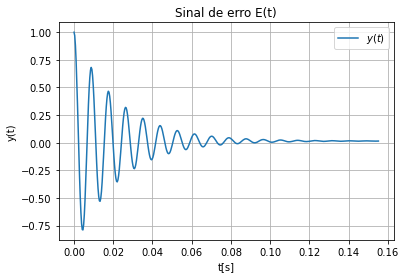

In [110]:
print("Limite do sinal de erro: "+str(lim_sinal_erro(C)))

E = sinal_erro(S) # E(s) = r(s)-Y(s)
print(E)

y, t = step(E)
plt.plot(t, y)

r = A*np.ones(np.shape(y))



plt.ylabel('y(t)')
plt.xlabel('t[s]')
plt.title('Sinal de erro E(t)')
plt.legend(['$y(t)$'])

plt.grid(True)
plt.show(block=False)


8 s^2 + 712 s + 6.337e+04
-------------------------
 s^2 + 89 s + 5.149e+05

Valor maximo:8.0


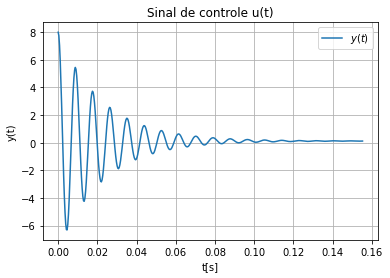

In [111]:
Sc = ft_controle_referencia(G1,C)
print(Sc)
print("Valor maximo:"+str(valor_maximo(Sc)))
y, t = step(Sc)
plt.plot(t, y)

r = A*np.ones(np.shape(y))

plt.ylabel('y(t)')
plt.xlabel('t[s]')
plt.title('Sinal de controle u(t)')
plt.legend(['$y(t)$'])

plt.grid(True)
plt.show(block=False)

---

#### Caso 4

Para as mesmas condições do caso 1 ($r(t)=1(t)$ e $d(t) = 0$), encontre o valor de $K_p$ necessário para que o erro de regime permanente seja igual a $10\%$ do valor da entrada $u(t)$, ou seja, como a entrada é degrau $u(t)=1(t)$, o valor final do erro deve ser $0.1$.

Para o valor de $K_p$ encontrado, obtenha os seguintes sinais de resposta:

1. Saída do sistema, $y(t)$, sobreposta com a referência degrau unitário, r(t) = 1(t). Características de desempenho da resposta de malha fechada.

2. Sinal de erro, $e(t)$. Valor final do sinal do erro. Porcentagem do erro em relação ao valor de entrada.

3. Sinal de controle, $u(t)$. Valor máximo do módulo do sinal de controle.

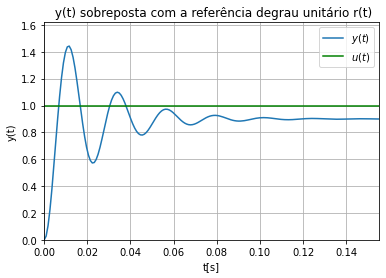

Valor final:1
Valor maximo:1.442377627622827
Tempo Subida:0.004460645278950107
Tempo de Acomodacao:0.08207587313268196
Tempo de pico e sobresinal:(0.011597677725270277, 0.44237762762282706)


In [112]:
C = 1.125
A = 1

S = ft_saida_referencia(G1,C)

y, t = step(S) # Y(s)
plt.plot(t, y)

r = A*np.ones(np.shape(y))

plt.plot(t, r, 'g')

plt.ylabel('y(t)')
plt.xlabel('t[s]')
plt.title(' y(t) sobreposta com a referência degrau unitário r(t)')
plt.legend(['$y(t)$','$u(t)$'])
plt.axis([0,t[-1],0,1.8*y[-1]])
plt.grid(True)
plt.show(block=False)


print("Valor final:"+str(valor_final(S)))
print("Valor maximo:"+str(valor_maximo(S)))
print("Tempo Subida:"+str(tempo_subida(S)))
print("Tempo de Acomodacao:"+str(tempo_acomodacao(S)))
print("Tempo de pico e sobresinal:"+str(tempo_pico_sobressinal(S)))


Limite do sinal de erro: 0.1

  s^2 + 89 s + 7921
----------------------
s^2 + 89 s + 7.921e+04



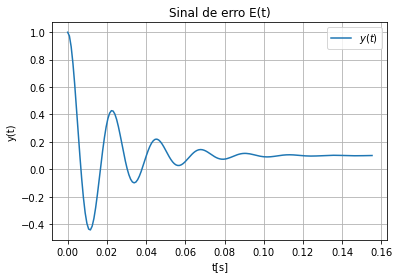

In [113]:
print("Limite do sinal de erro: "+str(lim_sinal_erro(C)))

E = sinal_erro(S) # E(s) = r(s)-Y(s)
print(E)

y, t = step(E)
plt.plot(t, y)

r = A*np.ones(np.shape(y))



plt.ylabel('y(t)')
plt.xlabel('t[s]')
plt.title('Sinal de erro E(t)')
plt.legend(['$y(t)$'])

plt.grid(True)
plt.show(block=False)


1.125 s^2 + 100.1 s + 8911
--------------------------
  s^2 + 89 s + 7.921e+04

Valor maximo:1.125


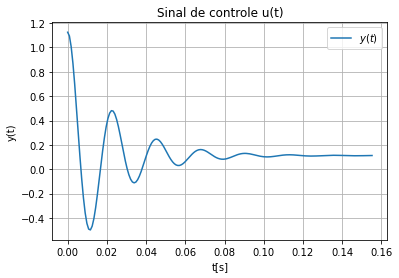

In [114]:
Sc = ft_controle_referencia(G1,C)
print(Sc)
print("Valor maximo:"+str(valor_maximo(Sc)))
y, t = step(Sc)
plt.plot(t, y)

r = A*np.ones(np.shape(y))

plt.ylabel('y(t)')
plt.xlabel('t[s]')
plt.title('Sinal de controle u(t)')
plt.legend(['$y(t)$'])

plt.grid(True)
plt.show(block=False)

---

### Análise dos Resultados



* Comente sobre o efeito do aumento do ganho proporcional no valor do erro em regime permanente, no valor do tempo de subida, no valor do tempo de acomodação, e no valor máximo do módulo do sinal de controle.

R: Com o aumento do ganho proporcional o erro tende a diminuir consistentemente, o tempo de subida tende a cair com o aumento do ganho proporcional, não se nota alteração expressiva no tempo de acomodação e o valor máximo do módulo de controle aumenta proporcionalmente ao valor do ganho proporcional.

* É possível zerar completamente o erro de regime permanente do sistema de malha fechada utilizando um controle proporcional?

R: Não, o erro tende a 0 quando Kp tende a infinito porém esses valores não são alcançáveis em um sistema real.





---


## Gerar Relatório em PDF

As linhas a seguir só precisam ser executadas para gerar um pdf para entrega. **Após grear o PDF e antes de submeter no Moodle, renomeie o arquivo PDF incluindo no nome do arquivo o seu N.USP.**

In [73]:
#Instalação de recursos para gerar PDF do relatório
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc --quiet 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japanese-mincho | fonts-ipa

In [74]:
#Monta o google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [83]:
#Conversão em PDF
# Altere com comando a seguir com o path e o nome do deste notebbok no seu Google Drive
!jupyter nbconvert --to PDF "/content/drive/My Drive/Colab Notebooks/sel0620_tarefa4_python.ipynb"

[NbConvertApp] Converting notebook /content/drive/My Drive/Colab Notebooks/sel0620_tarefa4_python.ipynb to PDF
[NbConvertApp] Support files will be in sel0620_tarefa4_python_files/
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Writing 188047 bytes to ./notebook.tex
[NbConver

In [80]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('sel0620_tarefa4_python.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/sel0620_tarefa4_python.ipynb to pdf
[NbConvertApp] Support files will be in sel0620_tarefa4_python_files/
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConvertApp] Making directory ./sel0620_tarefa4_python_files
[NbConve

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'